In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu HPG và chia dataset theo tỉ lệ 7:2:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

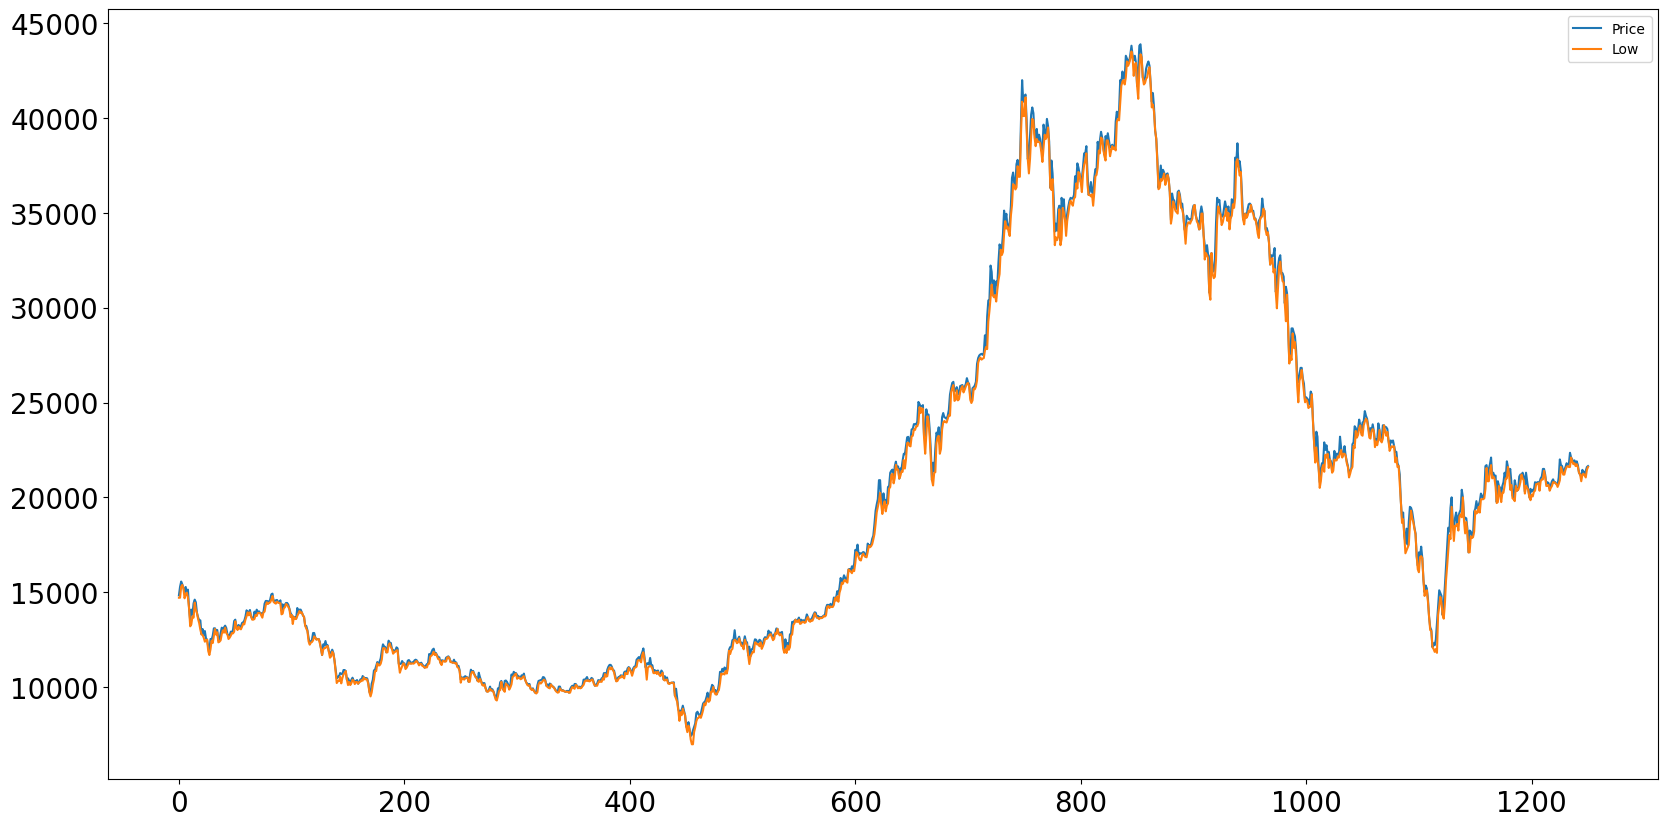

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2187642601016335,
 0.6654721662261358,
 15,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18731.487268410645)

In [ ]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [ ]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-7.395504537849762,
 7.797592879227417e-11,
 14,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18715.811266993263)

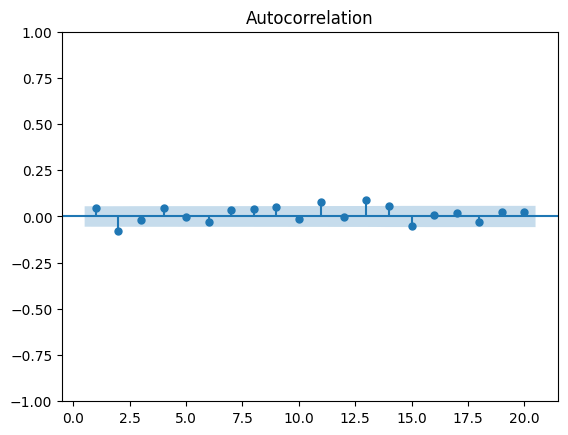

In [ ]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.2 MB/s eta 0:00:00


In [ ]:
df

,Price,Low
0,14831.7,14706.0
1,15284.1,14706.0
2,15560.7,15284.1
3,15409.8,15384.7
4,15233.9,15208.7
...,...,...
1246,21350.0,21250.0
1247,21200.0,21150.0
1248,21400.0,21050.0
1249,21600.0,21450.0


In [ ]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=13137.331, Time=3.06 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=13683.328, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=13496.411, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=inf, Time=0.52 sec
 ARIMA(2,2,2)(0,0,1)[5]             : AIC=inf, Time=6.51 sec
 ARIMA(2,2,2)(1,0,0)[5]             : AIC=inf, Time=6.87 sec
 ARIMA(2,2,2)(2,0,1)[5]             : AIC=13146.576, Time=11.07 sec
 ARIMA(2,2,2)(1,0,2)[5]             : AIC=13142.450, Time=10.68 sec
 ARIMA(2,2,2)(0,0,0)[5]             : AIC=inf, Time=3.03 sec
 ARIMA(2,2,2)(0,0,2)[5]             : AIC=13142.600, Time=4.77 sec
 ARIMA(2,2,2)(2,0,0)[5]             : AIC=inf, Time=3.61 sec
 ARIMA(2,2,2)(2,0,2)[5]             : AIC=inf, Time=8.03 sec
 ARIMA(1,2,2)(1,0,1)[5]             : AIC=13135.538, Time=4.45 sec
 ARIMA(1,2,2)(0,0,1)[5]             : AIC=inf, Time=5.80 sec
 ARIMA(1,2,2)(1,0,0)[5]             : AIC=inf, Time=2.95 se

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(1,2,2), seasonal_order=(1, 0 , 1, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([36478.9, 36706. , 37008.7, 36781.6, 36100.5, 34435.5, 34813.9,
       35608.6, 35419.4, 35116.6, 35041. , 34965.3, 36100.5, 35797.8,
       35268. , 35192.3, 34889.6, 34132.8, 33375.9, 34246.3, 34473.3,
       34511.2, 34435.5, 34586.9, 34700.4, 35268. , 35419.4, 34889.6,
       34549. , 34435.5, 34132.8, 34170.6, 34965.3, 34965.3, 33830. ,
       32543.4, 32884. , 32770.5, 32619.1, 30802.7, 30424.3, 32884. ,
       31786.6, 31559.6, 31635.2, 32543.4, 34586.9, 35343.7, 35041. ,
       34927.4, 34359.8, 34511.2, 34813.9, 34851.7, 35230.2, 34586.9,
       35003.1, 34132.8, 34738.2, 34851.7, 35457.2, 35268. , 35797.8,
       37689.8, 37841.2, 37425. , 36970.9, 37160.1, 35457.2, 34662.5,
       34397.7, 34965.3, 34738.2, 34851.7, 35116.6, 35041. , 35419.4,
       35078.8, 34965.3, 34662.5, 34662.5, 34359.8, 33905.7, 33678.7,
       34624.7, 34776.1, 34813.9, 35230.2, 35078.8, 34094.9, 33830. ,
       33981.4, 33413.8, 32278.5, 32467.8, 32619.1, 31862.3, 32051.5,
       30840.6, 2997

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
last_index = df.index[-1]
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([16350., 17200., 18000., 17800., 19500., 18600., 17700., 18500.,
       18500., 18600., 18250., 19000., 19100., 18950., 20000., 18750.,
       18100., 18700., 18100., 17100., 17100., 17950., 17850., 17900.,
       18200., 19300., 19150., 19200., 19500., 19200., 19900., 19900.,
       19900., 19950., 20450., 21550., 20850., 20850., 21350., 21700.,
       21000., 21100., 21000., 20550., 19700., 19750., 20600., 20150.,
       19750., 20250., 20250., 20600., 21000., 21000., 21600., 21200.,
       20400., 20650., 19950., 19900., 19800., 20600., 20350., 20400.,
       20550., 20800., 21200., 21000., 20900., 20200., 20600., 20500.,
       20400., 20000., 19850., 20150., 20050., 20300., 20350., 20700.,
       20700., 20750., 20350., 20850., 20950., 20950., 21400., 21100.,
       20600., 20600., 20650., 20350., 20500., 20600., 20800., 20800.,
       20750., 20700., 20550., 20700., 20900., 21600., 21400., 21200.,
       21200., 21450., 21600., 21650., 21600., 21600., 22100., 21900.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[43177.66564266 43208.93852077 43240.21139889 43271.484277
 43302.75715511 43334.03003323 43365.30291134 43396.57578946
 43427.84866757 43459.12154569 43490.3944238  43521.66730192
 43552.94018003 43584.21305815 43615.48593626 43646.75881438
 43678.03169249 43709.30457061 43740.57744872 43771.85032684
 43803.12320495 43834.39608307 43865.66896118 43896.9418393
 43928.21471741 43959.48759553 43990.76047364 44022.03335176
 44053.30622987 44084.57910799]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 465.53860256402777
Testing RMSE: 536.433015800979
Validation MAPE: 1.5299837866360533
Testing MAPE: 1.3696767417198987
Validation MAE: 310.7142857160584
Testing MAE: 344.81400000193696


**8. Vẽ biểu đồ**

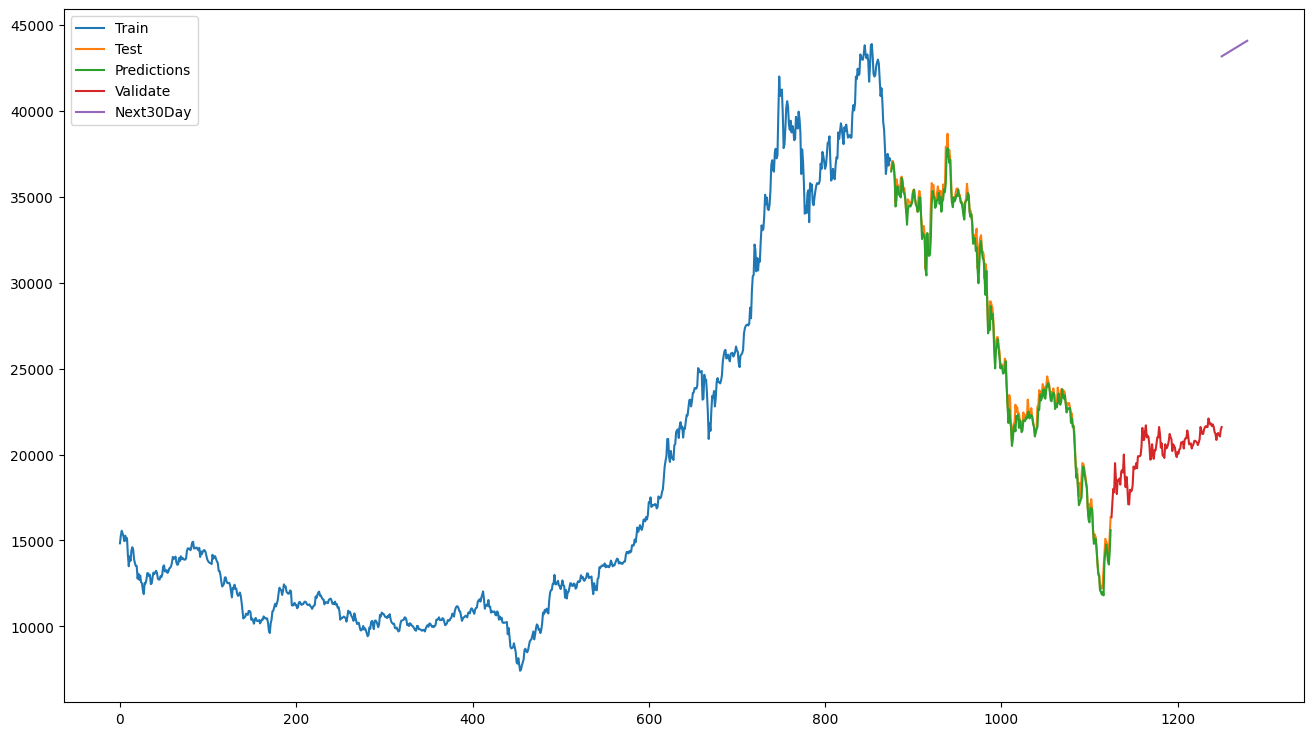

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()